## We want to format our annotated data to give to the LLM for finetuning.
----------------------

Few things to note:

1. this notebook has all the categories
2. each sentence is being extracted separately to create i/p and o/p
3. has the code for getting the .txt and .csv file.


----------------

Also regarding the partition of the sentences:

on LANN the single sentences where like (just one sentence):

"Grabs paddles, life jackets, towels, and a change of clothing and puts these in a bag. Puts the bag in the car. Gets in the car and starts driving to friend's house."

here it is like (3 separate sentences):

"Grabs paddles, life jackets, towels, and a change of clothing and puts these in a bag."

"Puts the bag in the car."

"Gets in the car and starts driving to friend's house."

In [ ]:
#import libraries
from google.colab import drive
import json
import re
import os
import csv
import pandas as pd

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


The final data should be in the format similat to:
```

"### Task:
Your task is to generate an HTML version of an input text, using HTML <span> tags to mark up specific entities.

### Entity Markup Guides:
Use <span class=""problem""> to denote a medical problem.
Use <span class=""treatment""> to denote a treatment.
Use <span class=""test""> to denote a test.
Use <span class=""drug""> to denote a drug.

### Entity Definitions:
Medical Problem: The abnormal condition that happens physically or mentally to a patient.
Treatment: The procedures, interventions, and substances given to a patient for treating a problem.
Drug: Generic or brand name of a single medication or a collective name of a group of medication.
Test: A medical procedure performed (i) to detect or diagnose a problem, (ii) to monitor diseases, disease processes, and susceptibility, or (iii) to determine a course of treatment.

### Input Text: The tympanic membranes are normal appearing with pearly color , normal - appearing landmarks and normal light reflex . <EOS>
### Output Text:","The tympanic membranes are normal appearing with pearly color , normal - appearing landmarks and normal <span class=""test"">light reflex</span> . <EOS>"
```




We want to test how the code works for one note

In [ ]:
file_path = "/content/drive/MyDrive/LLM for Medical Applications/LLM development/Annotated_179/MI02_ZoomTraining1_02_13_23.json"


with open(file_path, 'r') as f:
  data = json.load(f)

data

{'filename': '/usr/lann/annotation/corpus/read/0/vipinakk/MI02_ZoomTraining1_02_13_23.json',
 'content': 'Building his parents a TV stand\r\n\r\nGrabs the heavy box from the garage\r\nThe garage is a bit cold, and he can feel the coldness on him\r\nTries to pick up the box on his own but needs his brother to help because it is too heavy\r\nThey are being careful as they walk up the stairs to the living room (one of them is walking backward)\r\nThey accidentally slam it into the wall, which is annoying for both of them\r\nPlaces the box down and tries to open it with his hands, but it slides in an uncomfortable way similar to a paper cut, decides to look for a knife instead. This is also annoying.\r\nHis dad brings him a knife and a toolbox, and he slices the box open\r\nHe looks into the open box and sees that there is a ton of pieces to assemble (this is frustrating for him)\r\nFinds the instruction manual and begins slowly taking each piece out 1-by-1 and placing them organized on th

# Part 1:

Steps for writing the code:

1.   Preparing the entity definitions portion and the "constants" in line given for fine-tuning
2.   Figure out how to extract sentence by sentence
3. Figuring out how to add the "term" in the nested output

Repeate the same with reduced category > part 2

## Template for the constant part --->


The constant portion would look like:

```
"### Task:
Your task is to identify and annotate specific medical entities in the given text. For each entity found, you should provide an output in JSON format that includes the following information: The start index of the entity in the text,The end index of the entity in the text, The extracted entity text, and The entity type

### Entity Markup Guides:
use "visual" to denote a mention of visual elements.
use "visual_color" to denote mention of color of an object.
use "visual_brightness" to denote mention of brightness.
use "visual_shape" to denote mention of shape of an object.
use "visual_size" to denote mention of size of an object.
use "visual_num_quant" to denote mention of number of an physical object.
use "visual_texture" to denote mention of texture of an physical object.
use "visual_pattern" to denote mention of pattern of an physical object.
use "visual_motion" to denote mention of motions observed.
use "visual_spatial" to denote mention of position of an physical object.
use "somatosensory" to denote the mention of physical sensation.
use "somato_touch" to denote the mention of physical tactile sensation.
use "somato_pain" to denote the mention of pain/discomfort from external sources.
use "somato_temp" to denote the mention of temperature sensation from external sources.
use "somato_pressure" to denote the mention of sensation of pressure.
use "somato_vibration" to denote the mention of sensations of rapid oscillations on skin.
use "somato_proprio" to denote the mention of awareness of body position and movement.
use "somato_kinesthesia" to denote the mention of sensations realted to body moments.
use "smell" to denote the mention of olfactory sensations.
use "sound" to denote the mention of perception of hearing.
use "taste" to denote the mention of senstation of gustation.
use "introception" to denote the mention of internal bodily sensations.
use "introception_pulse_hb" to denote the mention of awareness of pulse or heartbeats.
use "introception_breathing" to denote the mention of act/awareness of breathing.
use "introception_hunger" to denote the mention of sensations hunger.
use "introception_satiety" to denote the mention of sensations of being full after a meal/after food.
use "introception_thirst" to denote the mention of feeling dehydrated.
use "introception_temp" to denote the mention of internal sensations of being hot or cold.
use "introception_pain" to denote the mention of the internal pain.
use "introception_energy_level" to denote the mention of the sensations related to the amount of energy or fatigue.
use "introception_tension" to denote the mention of sensations of bodily tension.
use "introception_urine_bowels" to denote the mention of sensations indicating the need to relieve oneself.
use "time" to denote the mention of time.
use "time_of_day" to denote the mention the time of day.
use "time_season" to denote the mention of the season.
use "time_month" to denote the mention of the month.
use "time_holiday" to denote the mention of the holiday/ special day.
use "time_day_of_week" to denote the mention of the specific day of the week.
use "location" to denote the mention of the location.
use "action" to denote the mention of an action done.
use "social_interaction" to denote the mention of the interactions between people where the subject is interacting with others.
use "emotion" to denote the mention of the subjects emotions.
use "thought" to denote the mention of the subject's thoughts.
use "thought_memory" to denote the mention of recall of events.
use "thought_judgment" to denote the judgement made by the subject's decision.
use "thought_self_reflection" to denote the self-reflection mentions of the subject.
use "thought_mentalizing" to denote the subject understanding/awareness of others emotions.
use "thought_thinking" to denote the mention of the subject's general cognitive processing activities.

### Entity Definitions:
visual: Perceptions related to sight, including attributes like color, size, shape, patterns, movement, and spatial relationships between objects.
visual_color: Description of hue, tint, or shade of an object.
visual_brightness: Description of light intensity or glare.
visual_shape: Description of the form or outline of objects.
visual_size: Description of the dimension or magnitude of objects.
visual_num_quant: Description of the count or amount of physical objects.
visual_texture: Description of the surface characteristics or feel.
visual_pattern: Description of repeated designs or regular arrangements.
visual_motion: Description of movement of objects, seen visually, includes the actions done by others.
visual_spatial: Description of the positioning or arrangement of objects in space.
somatosensory: Physical sensations felt through the skin or body, such as touch, temperature, pain, pressure, vibration, and body movement or position.
somato_touch: Sensations of physical contact.
somato_pain: Sensations of physical discomfort originating from the skin or muscles, from external reasons.
somato_temp: Sensations of heat or cold perceived on the skin, from external reasons.
somato_pressure: Sensations of force applied to the skin
somato_vibration: Sensations of rapid oscillations felt on the skin.
somato_proprio: Awareness of body position and movement.
somato_kinesthesia: Sensations related to body movements and the feel of muscles being moved.
smell: Sensory experiences related to smell, including pleasant or unpleasant odors.
sound: Perceptions related to hearing, including sounds like voices, machinery, or environmental noises but not limited to those only.
taste: Sensations related to the sense of taste, such as flavors experienced by the subject.
introception: Internal bodily sensations and physiological states, including awareness of heartbeat, breathing, hunger, thirst, internal temperature, pain (non-external), energy levels, and muscle tension.
introception_pulse_hb: Awareness of heartbeats or pulse.
introception_breathing: Sensations related to the act of breathing.
introception_hunger: Sensations of needing food.
introception_satiety: Sensations of being full after a meal/after food.
introception_thirst: Sensations of needing liquid, mention of feeling dehydrated.
introception_temp: Internal sensations of being hot or cold.
introception_pain: Internal physical discomfort that is not externally induced
introception_energy_level: Sensations related to the amount of energy or fatigue.
introception_tension: Sensations of muscle contraction or mental strain.
introception_urine_bowels: Sensations indicating the need to relieve oneself.
time: This category captures temporality, as well as references to time, including specific times of day, days of the week, months, seasons, and holidays or special days.
time_of_day: Specific mentions of time points during the day.
time_day_of_week: Mentions of a specific day in the week.
time_season: Mentions of periods within the year, including references to seasons, like Spring, Summer, Fall, Winter, or Rainy.
time_month: Mentions of specific months.
time_holiday: Mentions of holidays or important dates or special days.
location: References to places or settings where actions or events occur. It includes specific locations (e.g., a room or city) or general descriptions of spatial positioning.
acion: Descriptions of physical or mental actions performed by the subject or others, this does not entail mental action or others actions.
social_interaction: This category includes references to interactions or exchanges between people. It covers both verbal communication and non-verbal social interactions, such as gestures or expressions.
emotion: The subject’s emotional experiences or feelings. It includes both positive and negative emotions.
thought: Captures internal mental processes and reflections that do not necessarily lead to concrete actions or plans. It includes memories, judgments, self-reflections, decision-making, and attributions of thoughts to others, and mentalizing.
thought_memory: Recall of past events, emotions, or facts.
thought_judgment: Cognitive evaluations or decisions made.
thought_self_reflection: Reflections on one's thoughts or actions.
thought_mentalizing: Attributing thoughts or feelings to oneself or others.
thought_thinking: General cognitive processing activities.


### Input Text: "Morning Routine: Making breakfast and coffee
He woke up and went to his bathroom to brush his teeth and wash his face."
### Output Text: (
text ="Morning Routine: Making breakfast and coffee
He woke up and went to his bathroom to brush his teeth and wash his face."
annotations = {
    Annotation(start=17, end=33, term="Making breakfast", label="action"),
    Annotation(start=17, end=44, term="Making breakfast and coffee", label="action"),
    Annotation(start=49, end=56, term="woke up", label="action"),
    Annotation(start=61, end=81, term="went to his bathroom", label="action"),
    Annotation(start=69, end=81, term="his bathroom", label="location"),
    Annotation(start=85, end=100, term="brush his teeth", label="action"),
    Annotation(start=105, end=118, term="wash his face", label="action"),
}
)
```

## trying for different different split >>  ?<=\.|\?|!)\s*(?=\S)|\r\n|\n

In [ ]:
def extract_sentence_and_annotations(json_data):
    content = json_data['content']
    sentences = re.split(r'(?<=\.|\?|!)\s*(?=\S)|\r\n|\n', content.strip())
    sentences = [s.strip() for s in sentences if s.strip()]


    for sentence in sentences:
        start_index = content.index(sentence)
        end_index = start_index + len(sentence)

        annotations = []
        for index, data in json_data['indexes'].items():
            if 'Entity' in data:
                for entity in data['Entity']:
                    if start_index <= entity['begin'] < end_index:
                        annotations.append({
                            'start': entity['begin'] - start_index,
                            'end': min(entity['end'], end_index) - start_index,
                            'term': sentence[entity['begin'] - start_index:min(entity['end'], end_index) - start_index],
                            'label': entity['semantic']
                        })

        print(f"### Input Text: \"{sentence}\"")
        print("### Output Text: (")
        print(f"text =\"{sentence}\"")
        print("annotations = {")
        for ann in annotations:
            print(f"    Annotation(start={ann['start']}, end={ann['end']}, term=\"{ann['term']}\", label=\"{ann['label']}\"),")
        print("}")
        print(")")
        print()

# Loading the first JSON file as data
with open("/content/drive/MyDrive/LLM for Medical Applications/LLM development/Annotated_179/MI02_ZoomTraining1_02_13_23.json", 'r') as file:
    json_data = json.load(file)

# get the sentences and annotations as i/p and o/p
extract_sentence_and_annotations(json_data)



### Input Text: "Building his parents a TV stand"
### Output Text: (
text ="Building his parents a TV stand"
annotations = {
    Annotation(start=0, end=31, term="Building his parents a TV stand", label="action"),
}
)

### Input Text: "Grabs the heavy box from the garage"
### Output Text: (
text ="Grabs the heavy box from the garage"
annotations = {
    Annotation(start=0, end=35, term="Grabs the heavy box from the garage", label="action"),
    Annotation(start=10, end=19, term="heavy box", label="somatosensory"),
    Annotation(start=29, end=35, term="garage", label="location"),
}
)

### Input Text: "The garage is a bit cold, and he can feel the coldness on him"
### Output Text: (
text ="The garage is a bit cold, and he can feel the coldness on him"
annotations = {
    Annotation(start=4, end=10, term="garage", label="location"),
    Annotation(start=4, end=24, term="garage is a bit cold", label="somato_temp"),
    Annotation(start=37, end=61, term="feel the coldness on him", label="s

## Now addition of the template to these input and output sentences

In [ ]:
def extract_sentence_and_annotations(json_data):
    content = json_data['content']
    # sentences = re.split(r'(?<=[.!?])\s+', content)
    sentences = re.split(r'(?<=\.|\?|!)\s*(?=\S)|\r\n|\n', content.strip()) # this new split seems better than the first
    sentences = [s.strip() for s in sentences if s.strip()]

    template = '''"### Task:
Your task is to identify and annotate specific medical entities in the given text. For each entity found, you should provide an output in JSON format that includes the following information: The start index of the entity in the text,The end index of the entity in the text, The extracted entity text, and The entity type

### Entity Markup Guides:
use "visual" to denote a mention of visual elements.
use "visual_color" to denote mention of color of an object.
use "visual_brightness" to denote mention of brightness.
use "visual_shape" to denote mention of shape of an object.
use "visual_size" to denote mention of size of an object.
use "visual_num_quant" to denote mention of number of an physical object.
use "visual_texture" to denote mention of texture of an physical object.
use "visual_pattern" to denote mention of pattern of an physical object.
use "visual_motion" to denote mention of motions observed.
use "visual_spatial" to denote mention of position of an physical object.
use "somatosensory" to denote the mention of physical sensation.
use "somato_touch" to denote the mention of physical tactile sensation.
use "somato_pain" to denote the mention of pain/discomfort from external sources.
use "somato_temp" to denote the mention of temperature sensation from external sources.
use "somato_pressure" to denote the mention of sensation of pressure.
use "somato_vibration" to denote the mention of sensations of rapid oscillations on skin.
use "somato_proprio" to denote the mention of awareness of body position and movement.
use "somato_kinesthesia" to denote the mention of sensations realted to body moments.
use "smell" to denote the mention of olfactory sensations.
use "sound" to denote the mention of perception of hearing.
use "taste" to denote the mention of senstation of gustation.
use "introception" to denote the mention of internal bodily sensations.
use "introception_pulse_hb" to denote the mention of awareness of pulse or heartbeats.
use "introception_breathing" to denote the mention of act/awareness of breathing.
use "introception_hunger" to denote the mention of sensations hunger.
use "introception_satiety" to denote the mention of sensations of being full after a meal/after food.
use "introception_thirst" to denote the mention of feeling dehydrated.
use "introception_temp" to denote the mention of internal sensations of being hot or cold.
use "introception_pain" to denote the mention of the internal pain.
use "introception_energy_level" to denote the mention of the sensations related to the amount of energy or fatigue.
use "introception_tension" to denote the mention of sensations of bodily tension.
use "introception_urine_bowels" to denote the mention of sensations indicating the need to relieve oneself.
use "time" to denote the mention of time.
use "time_of_day" to denote the mention the time of day.
use "time_season" to denote the mention of the season.
use "time_month" to denote the mention of the month.
use "time_holiday" to denote the mention of the holiday/ special day.
use "time_day_of_week" to denote the mention of the specific day of the week.
use "location" to denote the mention of the location.
use "action" to denote the mention of an action done.
use "social_interaction" to denote the mention of the interactions between people where the subject is interacting with others.
use "emotion" to denote the mention of the subjects emotions.
use "thought" to denote the mention of the subject's thoughts.
use "thought_memory" to denote the mention of recall of events.
use "thought_judgment" to denote the judgement made by the subject's decision.
use "thought_self_reflection" to denote the self-reflection mentions of the subject.
use "thought_mentalizing" to denote the subject understanding/awareness of others emotions.
use "thought_thinking" to denote the mention of the subject's general cognitive processing activities.

### Entity Definitions:
visual: Perceptions related to sight, including attributes like color, size, shape, patterns, movement, and spatial relationships between objects.
visual_color: Description of hue, tint, or shade of an object.
visual_brightness: Description of light intensity or glare.
visual_shape: Description of the form or outline of objects.
visual_size: Description of the dimension or magnitude of objects.
visual_num_quant: Description of the count or amount of physical objects.
visual_texture: Description of the surface characteristics or feel.
visual_pattern: Description of repeated designs or regular arrangements.
visual_motion: Description of movement of objects, seen visually, includes the actions done by others.
visual_spatial: Description of the positioning or arrangement of objects in space.
somatosensory: Physical sensations felt through the skin or body, such as touch, temperature, pain, pressure, vibration, and body movement or position.
somato_touch: Sensations of physical contact.
somato_pain: Sensations of physical discomfort originating from the skin or muscles, from external reasons.
somato_temp: Sensations of heat or cold perceived on the skin, from external reasons.
somato_pressure: Sensations of force applied to the skin
somato_vibration: Sensations of rapid oscillations felt on the skin.
somato_proprio: Awareness of body position and movement.
somato_kinesthesia: Sensations related to body movements and the feel of muscles being moved.
smell: Sensory experiences related to smell, including pleasant or unpleasant odors.
sound: Perceptions related to hearing, including sounds like voices, machinery, or environmental noises but not limited to those only.
taste: Sensations related to the sense of taste, such as flavors experienced by the subject.
introception: Internal bodily sensations and physiological states, including awareness of heartbeat, breathing, hunger, thirst, internal temperature, pain (non-external), energy levels, and muscle tension.
introception_pulse_hb: Awareness of heartbeats or pulse.
introception_breathing: Sensations related to the act of breathing.
introception_hunger: Sensations of needing food.
introception_satiety: Sensations of being full after a meal/after food.
introception_thirst: Sensations of needing liquid, mention of feeling dehydrated.
introception_temp: Internal sensations of being hot or cold.
introception_pain: Internal physical discomfort that is not externally induced
introception_energy_level: Sensations related to the amount of energy or fatigue.
introception_tension: Sensations of muscle contraction or mental strain.
introception_urine_bowels: Sensations indicating the need to relieve oneself.
time: This category captures temporality, as well as references to time, including specific times of day, days of the week, months, seasons, and holidays or special days.
time_of_day: Specific mentions of time points during the day.
time_day_of_week: Mentions of a specific day in the week.
time_season: Mentions of periods within the year, including references to seasons, like Spring, Summer, Fall, Winter, or Rainy.
time_month: Mentions of specific months.
time_holiday: Mentions of holidays or important dates or special days.
location: References to places or settings where actions or events occur. It includes specific locations (e.g., a room or city) or general descriptions of spatial positioning.
acion: Descriptions of physical or mental actions performed by the subject or others, this does not entail mental action or others actions.
social_interaction: This category includes references to interactions or exchanges between people. It covers both verbal communication and non-verbal social interactions, such as gestures or expressions.
emotion: The subject’s emotional experiences or feelings. It includes both positive and negative emotions.
thought: Captures internal mental processes and reflections that do not necessarily lead to concrete actions or plans. It includes memories, judgments, self-reflections, decision-making, and attributions of thoughts to others, and mentalizing.
thought_memory: Recall of past events, emotions, or facts.
thought_judgment: Cognitive evaluations or decisions made.
thought_self_reflection: Reflections on one's thoughts or actions.
thought_mentalizing: Attributing thoughts or feelings to oneself or others.
thought_thinking: General cognitive processing activities.

'''

    for sentence in sentences:
        start_index = content.index(sentence)
        end_index = start_index + len(sentence)

        annotations = []
        for index, data in json_data['indexes'].items():
            if 'Entity' in data:
                for entity in data['Entity']:
                    if start_index <= entity['begin'] < end_index:
                        annotations.append({
                            'start': entity['begin'] - start_index,
                            'end': min(entity['end'], end_index) - start_index,
                            'term': sentence[entity['begin'] - start_index:min(entity['end'], end_index) - start_index],
                            'label': entity['semantic']
                        })

        print(template)
        print(f"### Input Text: \"{sentence}\"")
        print("### Output Text: (")
        print(f"text =\"{sentence}\"")
        print("annotations = {")
        for ann in annotations:
            print(f"    Annotation(start={ann['start']}, end={ann['end']}, term=\"{ann['term']}\", label=\"{ann['label']}\"),")
        print("}")
        print(")")
        print()


with open("/content/drive/MyDrive/LLM for Medical Applications/LLM development/Annotated_179/MI01_ZoomTraining10_03_05_2023.json", 'r') as file:
    json_data = json.load(file)


extract_sentence_and_annotations(json_data)


"### Task:
Your task is to identify and annotate specific medical entities in the given text. For each entity found, you should provide an output in JSON format that includes the following information: The start index of the entity in the text,The end index of the entity in the text, The extracted entity text, and The entity type

### Entity Markup Guides:
use "visual" to denote a mention of visual elements.
use "visual_color" to denote mention of color of an object.
use "visual_brightness" to denote mention of brightness.
use "visual_shape" to denote mention of shape of an object.
use "visual_size" to denote mention of size of an object.
use "visual_num_quant" to denote mention of number of an physical object.
use "visual_texture" to denote mention of texture of an physical object.
use "visual_pattern" to denote mention of pattern of an physical object.
use "visual_motion" to denote mention of motions observed.
use "visual_spatial" to denote mention of position of an physical object.


**Comment: for each new input text the character range count is also from 0 to n (rather than 1st input sentence 0 to n and 2nd input sentence n+1 to m).. so this is good!**

## Creating an automated code to access the "Annotated_179" folder and read all the 179 files > .txt version

In [ ]:
## trying again

def process_json_file(file_path, template):
    with open(file_path, 'r') as file:
        json_data = json.load(file)

    content = json_data['content']
    sentences = re.split(r'(?<=\.|\?|!)\s*(?=\S)|\r\n|\n', content.strip())
    sentences = [s.strip() for s in sentences if s.strip()]

    output = []

    for sentence in sentences:
        sentence = sentence.strip()
        if not sentence:
            continue

        start_index = content.index(sentence)
        end_index = start_index + len(sentence)

        annotations = []
        for index, data in json_data['indexes'].items():
            if 'Entity' in data:
                for entity in data['Entity']:
                    if start_index <= entity['begin'] < end_index:
                        annotations.append({
                            'start': entity['begin'] - start_index,
                            'end': min(entity['end'], end_index) - start_index,
                            'term': sentence[entity['begin'] - start_index:min(entity['end'], end_index) - start_index],
                            'label': entity['semantic']
                        })

        output.append(template)  # Add the template before each input-output pair
        output.append(f"### Input Text: \"{sentence}\"")
        output.append("### Output Text: (")
        output.append(f"text =\"{sentence}.\"")
        output.append("annotations = {")
        for ann in annotations:
            output.append(f"    Annotation(start={ann['start']}, end={ann['end']}, term=\"{ann['term']}\", label=\"{ann['label']}\"),")
        output.append("}")
        output.append(")")
        output.append("")

    return "\n".join(output)

def process_all_files(folder_path, template):
    all_output = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".json") and filename.startswith("MI"):
            file_path = os.path.join(folder_path, filename)
            all_output.append(process_json_file(file_path, template))

    return "\n".join(all_output)

# Constant template
template = '''"### Task:
Your task is to identify and annotate specific medical entities in the given text. For each entity found, you should provide an output in JSON format that includes the following information: The start index of the entity in the text,The end index of the entity in the text, The extracted entity text, and The entity type.

### Entity Markup Guides:
use "visual" to denote a mention of visual elements.
use "visual_color" to denote mention of color of an object.
use "visual_brightness" to denote mention of brightness.
use "visual_shape" to denote mention of shape of an object.
use "visual_size" to denote mention of size of an object.
use "visual_num_quant" to denote mention of number of an physical object.
use "visual_texture" to denote mention of texture of an physical object.
use "visual_pattern" to denote mention of pattern of an physical object.
use "visual_motion" to denote mention of motions observed.
use "visual_spatial" to denote mention of position of an physical object.
use "somatosensory" to denote the mention of physical sensation.
use "somato_touch" to denote the mention of physical tactile sensation.
use "somato_pain" to denote the mention of pain/discomfort from external sources.
use "somato_temp" to denote the mention of temperature sensation from external sources.
use "somato_pressure" to denote the mention of sensation of pressure.
use "somato_vibration" to denote the mention of sensations of rapid oscillations on skin.
use "somato_proprio" to denote the mention of awareness of body position and movement.
use "somato_kinesthesia" to denote the mention of sensations realted to body moments.
use "smell" to denote the mention of olfactory sensations.
use "sound" to denote the mention of perception of hearing.
use "taste" to denote the mention of senstation of gustation.
use "introception" to denote the mention of internal bodily sensations.
use "introception_pulse_hb" to denote the mention of awareness of pulse or heartbeats.
use "introception_breathing" to denote the mention of act/awareness of breathing.
use "introception_hunger" to denote the mention of sensations hunger.
use "introception_satiety" to denote the mention of sensations of being full after a meal/after food.
use "introception_thirst" to denote the mention of feeling dehydrated.
use "introception_temp" to denote the mention of internal sensations of being hot or cold.
use "introception_pain" to denote the mention of the internal pain.
use "introception_energy_level" to denote the mention of the sensations related to the amount of energy or fatigue.
use "introception_tension" to denote the mention of sensations of bodily tension.
use "introception_urine_bowels" to denote the mention of sensations indicating the need to relieve oneself.
use "time" to denote the mention of time.
use "time_of_day" to denote the mention the time of day.
use "time_season" to denote the mention of the season.
use "time_month" to denote the mention of the month.
use "time_holiday" to denote the mention of the holiday/ special day.
use "time_day_of_week" to denote the mention of the specific day of the week.
use "location" to denote the mention of the location.
use "action" to denote the mention of an action done.
use "social_interaction" to denote the mention of the interactions between people where the subject is interacting with others.
use "emotion" to denote the mention of the subjects emotions.
use "thought" to denote the mention of the subject's thoughts.
use "thought_memory" to denote the mention of recall of events.
use "thought_judgment" to denote the judgement made by the subject's decision.
use "thought_self_reflection" to denote the self-reflection mentions of the subject.
use "thought_mentalizing" to denote the subject understanding/awareness of others emotions.
use "thought_thinking" to denote the mention of the subject's general cognitive processing activities.

### Entity Definitions:
visual: Perceptions related to sight, including attributes like color, size, shape, patterns, movement, and spatial relationships between objects.
visual_color: Description of hue, tint, or shade of an object.
visual_brightness: Description of light intensity or glare.
visual_shape: Description of the form or outline of objects.
visual_size: Description of the dimension or magnitude of objects.
visual_num_quant: Description of the count or amount of physical objects.
visual_texture: Description of the surface characteristics or feel.
visual_pattern: Description of repeated designs or regular arrangements.
visual_motion: Description of movement of objects, seen visually, includes the actions done by others.
visual_spatial: Description of the positioning or arrangement of objects in space.
somatosensory: Physical sensations felt through the skin or body, such as touch, temperature, pain, pressure, vibration, and body movement or position.
somato_touch: Sensations of physical contact.
somato_pain: Sensations of physical discomfort originating from the skin or muscles, from external reasons.
somato_temp: Sensations of heat or cold perceived on the skin, from external reasons.
somato_pressure: Sensations of force applied to the skin
somato_vibration: Sensations of rapid oscillations felt on the skin.
somato_proprio: Awareness of body position and movement.
somato_kinesthesia: Sensations related to body movements and the feel of muscles being moved.
smell: Sensory experiences related to smell, including pleasant or unpleasant odors.
sound: Perceptions related to hearing, including sounds like voices, machinery, or environmental noises but not limited to those only.
taste: Sensations related to the sense of taste, such as flavors experienced by the subject.
introception: Internal bodily sensations and physiological states, including awareness of heartbeat, breathing, hunger, thirst, internal temperature, pain (non-external), energy levels, and muscle tension.
introception_pulse_hb: Awareness of heartbeats or pulse.
introception_breathing: Sensations related to the act of breathing.
introception_hunger: Sensations of needing food.
introception_satiety: Sensations of being full after a meal/after food.
introception_thirst: Sensations of needing liquid, mention of feeling dehydrated.
introception_temp: Internal sensations of being hot or cold.
introception_pain: Internal physical discomfort that is not externally induced
introception_energy_level: Sensations related to the amount of energy or fatigue.
introception_tension: Sensations of muscle contraction or mental strain.
introception_urine_bowels: Sensations indicating the need to relieve oneself.
time: This category captures temporality, as well as references to time, including specific times of day, days of the week, months, seasons, and holidays or special days.
time_of_day: Specific mentions of time points during the day.
time_day_of_week: Mentions of a specific day in the week.
time_season: Mentions of periods within the year, including references to seasons, like Spring, Summer, Fall, Winter, or Rainy.
time_month: Mentions of specific months.
time_holiday: Mentions of holidays or important dates or special days.
location: References to places or settings where actions or events occur. It includes specific locations (e.g., a room or city) or general descriptions of spatial positioning.
acion: Descriptions of physical or mental actions performed by the subject or others, this does not entail mental action or others actions.
social_interaction: This category includes references to interactions or exchanges between people. It covers both verbal communication and non-verbal social interactions, such as gestures or expressions.
emotion: The subject’s emotional experiences or feelings. It includes both positive and negative emotions.
thought: Captures internal mental processes and reflections that do not necessarily lead to concrete actions or plans. It includes memories, judgments, self-reflections, decision-making, and attributions of thoughts to others, and mentalizing.
thought_memory: Recall of past events, emotions, or facts.
thought_judgment: Cognitive evaluations or decisions made.
thought_self_reflection: Reflections on one's thoughts or actions.
thought_mentalizing: Attributing thoughts or feelings to oneself or others.
thought_thinking: General cognitive processing activities.

'''

# Process all files
folder_path = "/content/drive/MyDrive/LLM for Medical Applications/LLM development/Annotated_179"
output = process_all_files(folder_path, template)

# Save to file
with open("training_data.txt", "w") as f:
    f.write(output)

print("Processing complete. Output saved to training_data.txt")


KeyboardInterrupt: 

# .csv version final file

In [ ]:
def process_json_file(file_path, template):
    with open(file_path, 'r') as file:
        json_data = json.load(file)

    content = json_data['content']
    sentences = re.split(r'(?<=\.|\?|!)\s*(?=\S)|\r\n|\n', content.strip())
    sentences = [s.strip() for s in sentences if s.strip()]

    output = []

    for sentence in sentences:
        sentence = sentence.strip()
        if not sentence:
            continue

        start_index = content.index(sentence)
        end_index = start_index + len(sentence)

        annotations = []
        for index, data in json_data['indexes'].items():
            if 'Entity' in data:
                for entity in data['Entity']:
                    if start_index <= entity['begin'] < end_index:
                        annotations.append({
                            'start': entity['begin'] - start_index,
                            'end': min(entity['end'], end_index) - start_index,
                            'term': sentence[entity['begin'] - start_index:min(entity['end'], end_index) - start_index],
                            'label': entity['semantic']
                        })

        unprocessed = template + f"\n\n### Input Text: \"{sentence}\"\n### Output Text: "
        processed = f"(\ntext =\"{sentence}.\"\nannotations = {{\n"
        for ann in annotations:
            processed += f"    Annotation(start={ann['start']}, end={ann['end']}, term=\"{ann['term']}\", label=\"{ann['label']}\"),\n"
        processed += "}\n)"

        output.append((unprocessed, processed))

    return output

def process_all_files(folder_path, template):
    all_output = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".json") and filename.startswith("MI"):
            file_path = os.path.join(folder_path, filename)
            all_output.extend(process_json_file(file_path, template))

    return all_output

# Constant template
template = '''"### Task:
Your task is to identify and annotate specific medical entities in the given text. For each entity found, you should provide an output in JSON format that includes the following information: The start index of the entity in the text,The end index of the entity in the text, The extracted entity text, and The entity type

### Entity Markup Guides:
use "visual" to denote a mention of visual elements.
use "visual_color" to denote mention of color of an object.
use "visual_brightness" to denote mention of brightness.
use "visual_shape" to denote mention of shape of an object.
use "visual_size" to denote mention of size of an object.
use "visual_num_quant" to denote mention of number of an physical object.
use "visual_texture" to denote mention of texture of an physical object.
use "visual_pattern" to denote mention of pattern of an physical object.
use "visual_motion" to denote mention of motions observed.
use "visual_spatial" to denote mention of position of an physical object.
use "somatosensory" to denote the mention of physical sensation.
use "somato_touch" to denote the mention of physical tactile sensation.
use "somato_pain" to denote the mention of pain/discomfort from external sources.
use "somato_temp" to denote the mention of temperature sensation from external sources.
use "somato_pressure" to denote the mention of sensation of pressure.
use "somato_vibration" to denote the mention of sensations of rapid oscillations on skin.
use "somato_proprio" to denote the mention of awareness of body position and movement.
use "somato_kinesthesia" to denote the mention of sensations realted to body moments.
use "smell" to denote the mention of olfactory sensations.
use "sound" to denote the mention of perception of hearing.
use "taste" to denote the mention of senstation of gustation.
use "introception" to denote the mention of internal bodily sensations.
use "introception_pulse_hb" to denote the mention of awareness of pulse or heartbeats.
use "introception_breathing" to denote the mention of act/awareness of breathing.
use "introception_hunger" to denote the mention of sensations hunger.
use "introception_satiety" to denote the mention of sensations of being full after a meal/after food.
use "introception_thirst" to denote the mention of feeling dehydrated.
use "introception_temp" to denote the mention of internal sensations of being hot or cold.
use "introception_pain" to denote the mention of the internal pain.
use "introception_energy_level" to denote the mention of the sensations related to the amount of energy or fatigue.
use "introception_tension" to denote the mention of sensations of bodily tension.
use "introception_urine_bowels" to denote the mention of sensations indicating the need to relieve oneself.
use "time" to denote the mention of time.
use "time_of_day" to denote the mention the time of day.
use "time_season" to denote the mention of the season.
use "time_month" to denote the mention of the month.
use "time_holiday" to denote the mention of the holiday/ special day.
use "time_day_of_week" to denote the mention of the specific day of the week.
use "location" to denote the mention of the location.
use "action" to denote the mention of an action done.
use "social_interaction" to denote the mention of the interactions between people where the subject is interacting with others.
use "emotion" to denote the mention of the subjects emotions.
use "thought" to denote the mention of the subject's thoughts.
use "thought_memory" to denote the mention of recall of events.
use "thought_judgment" to denote the judgement made by the subject's decision.
use "thought_self_reflection" to denote the self-reflection mentions of the subject.
use "thought_mentalizing" to denote the subject understanding/awareness of others emotions.
use "thought_thinking" to denote the mention of the subject's general cognitive processing activities.

### Entity Definitions:
visual: Perceptions related to sight, including attributes like color, size, shape, patterns, movement, and spatial relationships between objects.
visual_color: Description of hue, tint, or shade of an object.
visual_brightness: Description of light intensity or glare.
visual_shape: Description of the form or outline of objects.
visual_size: Description of the dimension or magnitude of objects.
visual_num_quant: Description of the count or amount of physical objects.
visual_texture: Description of the surface characteristics or feel.
visual_pattern: Description of repeated designs or regular arrangements.
visual_motion: Description of movement of objects, seen visually, includes the actions done by others.
visual_spatial: Description of the positioning or arrangement of objects in space.
somatosensory: Physical sensations felt through the skin or body, such as touch, temperature, pain, pressure, vibration, and body movement or position.
somato_touch: Sensations of physical contact.
somato_pain: Sensations of physical discomfort originating from the skin or muscles, from external reasons.
somato_temp: Sensations of heat or cold perceived on the skin, from external reasons.
somato_pressure: Sensations of force applied to the skin
somato_vibration: Sensations of rapid oscillations felt on the skin.
somato_proprio: Awareness of body position and movement.
somato_kinesthesia: Sensations related to body movements and the feel of muscles being moved.
smell: Sensory experiences related to smell, including pleasant or unpleasant odors.
sound: Perceptions related to hearing, including sounds like voices, machinery, or environmental noises but not limited to those only.
taste: Sensations related to the sense of taste, such as flavors experienced by the subject.
introception: Internal bodily sensations and physiological states, including awareness of heartbeat, breathing, hunger, thirst, internal temperature, pain (non-external), energy levels, and muscle tension.
introception_pulse_hb: Awareness of heartbeats or pulse.
introception_breathing: Sensations related to the act of breathing.
introception_hunger: Sensations of needing food.
introception_satiety: Sensations of being full after a meal/after food.
introception_thirst: Sensations of needing liquid, mention of feeling dehydrated.
introception_temp: Internal sensations of being hot or cold.
introception_pain: Internal physical discomfort that is not externally induced
introception_energy_level: Sensations related to the amount of energy or fatigue.
introception_tension: Sensations of muscle contraction or mental strain.
introception_urine_bowels: Sensations indicating the need to relieve oneself.
time: This category captures temporality, as well as references to time, including specific times of day, days of the week, months, seasons, and holidays or special days.
time_of_day: Specific mentions of time points during the day.
time_day_of_week: Mentions of a specific day in the week.
time_season: Mentions of periods within the year, including references to seasons, like Spring, Summer, Fall, Winter, or Rainy.
time_month: Mentions of specific months.
time_holiday: Mentions of holidays or important dates or special days.
location: References to places or settings where actions or events occur. It includes specific locations (e.g., a room or city) or general descriptions of spatial positioning.
acion: Descriptions of physical or mental actions performed by the subject or others, this does not entail mental action or others actions.
social_interaction: This category includes references to interactions or exchanges between people. It covers both verbal communication and non-verbal social interactions, such as gestures or expressions.
emotion: The subject’s emotional experiences or feelings. It includes both positive and negative emotions.
thought: Captures internal mental processes and reflections that do not necessarily lead to concrete actions or plans. It includes memories, judgments, self-reflections, decision-making, and attributions of thoughts to others, and mentalizing.
thought_memory: Recall of past events, emotions, or facts.
thought_judgment: Cognitive evaluations or decisions made.
thought_self_reflection: Reflections on one's thoughts or actions.
thought_mentalizing: Attributing thoughts or feelings to oneself or others.
thought_thinking: General cognitive processing activities.

'''

# Process all files
folder_path = "/content/drive/MyDrive/LLM for Medical Applications/LLM development/Annotated_179"
output = process_all_files(folder_path, template)

# Save to CSV file
with open("training_data.csv", "w", newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(["unprocessed", "processed"])
    writer.writerows(output)

print("Processing complete. Output saved to training_data.csv")


Processing complete. Output saved to training_data.csv


# **Some "edge-cases" and correction for them:**

Goal:
New files .csv and .txt with added context.

Expectation/ hypothesis: If used for training the LLM should have a minor improvement in understanding the context.

We had in some cases tagged two sentences with one continous tag- where the continous tag was gettign chopped off.

Speciafically example: MI03-training10

we have:

```
### Input Text: "They coordinate a date that will work for everyone."
### Output Text: (
text ="They coordinate a date that will work for everyone."
annotations = {
    Annotation(start=0, end=51, term="They coordinate a date that will work for everyone.", label="social_interaction"),
}
)

### Input Text: "Settle on a Tuesday"
### Output Text: (
text ="Settle on a Tuesday"
annotations = {
    Annotation(start=12, end=19, term="Tuesday", label="time_day_of_week"),
}
)

```



we want:


```
### Input Text: "They coordinate a date that will work for everyone."
### Output Text: (
text ="They coordinate a date that will work for everyone."
annotations = {
    Annotation(start=0, end=51, term="They coordinate a date that will work for everyone.", label="social_interaction"),
}
)

### Input Text: "Settle on a Tuesday"
### Output Text: (
text ="Settle on a Tuesday"
annotations = {
    Annotation(start=0, end=19, term="Settle on a Tuesday", label="social_interaction"),
    Annotation(start=12, end=19, term="Tuesday", label="time_day_of_week"),
}
)
```




also, there are cases that cause isssues such as: 1.5 being split as "1" and "5".. because of the previous splittling. further abbrivations like "oz." are also causing splits. --- Cant take care of this; the whole output is getting messed up.- We decided to let it be.
    
    
lets try to correct that

In [ ]:
file_path = "/content/drive/MyDrive/LLM for Medical Applications/LLM development/Annotated_179/MI03_ZoomTraining10_04_21_2023.json"


with open(file_path, 'r') as f:
  data = json.load(f)

data

{'filename': '/usr/lann/annotation/corpus/read/0/vipinakk/MI03_ZoomTraining10_04_21_2023.json',
 'content': "Charity Golf Tournament at his Country Club \r\n\r\n(Before the tournament)\r\nHis former neighbor calls him to invite him to help organize and play in a charity tournament\r\nHe writes out a cheque for donation\r\nThey coordinate a date that will work for everyone. Settle on a Tuesday\r\nHe calls up former contributors to see if they'd be willing to donate to the upcoming tournament as well\r\nThey organize the menu and format of the tournament\r\nDay of the tournament: \r\nHe arrives at the course. Everyone begins gathering and registering for the event \r\nEveryone is given instructions on their time slots \r\nHe tees off around 1 hour later \r\nHe plays a 4 1/2 hour round of golf \r\nAfter playing, he gathers inside the clubhouse with everyone to drink cocktails \r\nHe reviews the score sheet posted on the clubhouse walls \r\nDinner is served\r\nWhile they are eating, differ

In [ ]:
def extract_sentence_and_annotations(json_data):
    content = json_data['content']
    sentences = re.split(r'(?<=\.|\?|!)\s*(?=\S)|\r\n|\n', content.strip())
    sentences = [s.strip() for s in sentences if s.strip()]
    # sentence_pattern = r'(?<!\d\.)(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|!)\s+(?=[A-Z0-9])|(?<=\.|\?|!)\s*$|\r\n|\n'
    # sentences = re.split(sentence_pattern, content.strip())


    for i, sentence in enumerate(sentences):
        start_index = content.index(sentence)
        end_index = start_index + len(sentence)

        annotations = []
        for index, data in json_data['indexes'].items():
            if 'Entity' in data:
                for entity in data['Entity']:
                    # Check if the entity overlaps with the current sentence
                    if (start_index <= entity['begin'] < end_index or
                        start_index < entity['end'] <= end_index or
                        (entity['begin'] <= start_index and entity['end'] >= end_index)):
                    # if start_index <= entity['begin'] and entity['end'] <= end_index: # strict bounds


                        # Adjust start and end indices relative to the sentence
                        rel_start = max(0, entity['begin'] - start_index)
                        rel_end = min(len(sentence), entity['end'] - start_index)

                        annotations.append({
                            'start': rel_start,
                            'end': rel_end,
                            'term': sentence[rel_start:rel_end],
                            'label': entity['semantic']
                        })


        print(f"### Input Text: \"{sentence}\"")
        print("### Output Text: (")
        print(f"text =\"{sentence}\"")
        print("annotations = {")
        for ann in annotations:
            print(f"    Annotation(start={ann['start']}, end={ann['end']}, term=\"{ann['term']}\", label=\"{ann['label']}\"),")
        print("}")
        print(")")
        print()

# Loading the JSON file as data
with open("/content/drive/MyDrive/LLM for Medical Applications/LLM development/Annotated_179/MI02_ZoomTraining1_02_13_23.json", 'r') as file:
    json_data = json.load(file)

# get the sentences and annotations as i/p and o/p
extract_sentence_and_annotations(json_data)


### Input Text: "Building his parents a TV stand"
### Output Text: (
text ="Building his parents a TV stand"
annotations = {
    Annotation(start=0, end=31, term="Building his parents a TV stand", label="action"),
}
)

### Input Text: "Grabs the heavy box from the garage"
### Output Text: (
text ="Grabs the heavy box from the garage"
annotations = {
    Annotation(start=0, end=35, term="Grabs the heavy box from the garage", label="action"),
    Annotation(start=10, end=19, term="heavy box", label="somatosensory"),
    Annotation(start=29, end=35, term="garage", label="location"),
}
)

### Input Text: "The garage is a bit cold, and he can feel the coldness on him"
### Output Text: (
text ="The garage is a bit cold, and he can feel the coldness on him"
annotations = {
    Annotation(start=4, end=10, term="garage", label="location"),
    Annotation(start=4, end=24, term="garage is a bit cold", label="somato_temp"),
    Annotation(start=37, end=61, term="feel the coldness on him", label="s

### Apart from the above we would also like a filter for instances whrer the input just has  less than 3 characters.

In [ ]:
def extract_sentence_and_annotations(json_data):
    content = json_data['content']
    sentence_pattern = r'(?<!\d\.)(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|!)\s+(?=[A-Z0-9])|(?<=\.|\?|!)\s*$|\r\n|\n'
    sentences = re.split(sentence_pattern, content.strip())

    for i, sentence in enumerate(sentences):
        start_index = content.index(sentence)
        end_index = start_index + len(sentence)

        annotations = []
        for index, data in json_data['indexes'].items():
            if 'Entity' in data:
                for entity in data['Entity']:
                    # Check if the entity overlaps with the current sentence
                     if start_index <= entity['begin'] and entity['end'] <= end_index: # strict bounds:

                        # Adjust start and end indices relative to the sentence
                        rel_start = max(0, entity['begin'] - start_index)
                        rel_end = min(len(sentence), entity['end'] - start_index)

                        annotations.append({
                            'start': rel_start,
                            'end': rel_end,
                            'term': sentence[rel_start:rel_end],
                            'label': entity['semantic']
                        })

        # Filter sentences with fewer than three characters
        if len(sentence) >= 3:
            print(f"### Input Text: \"{sentence}\"")
            print("### Output Text: (")
            print(f"text =\"{sentence}\"")
            print("annotations = {")
            for ann in annotations:
                print(f"    Annotation(start={ann['start']}, end={ann['end']}, term=\"{ann['term']}\", label=\"{ann['label']}\"),")
            print("}")
            print(")")
            print()

# Loading the JSON file as data
with open("/content/drive/MyDrive/LLM for Medical Applications/LLM development/Annotated_179/MI02_ZoomTraining1_02_13_23.json", 'r') as file:
    json_data = json.load(file)

# Get the sentences and annotations as i/p and o/p
extract_sentence_and_annotations(json_data)


### Input Text: "Building his parents a TV stand"
### Output Text: (
text ="Building his parents a TV stand"
annotations = {
    Annotation(start=0, end=31, term="Building his parents a TV stand", label="action"),
}
)

### Input Text: "Grabs the heavy box from the garage"
### Output Text: (
text ="Grabs the heavy box from the garage"
annotations = {
    Annotation(start=0, end=35, term="Grabs the heavy box from the garage", label="action"),
    Annotation(start=10, end=19, term="heavy box", label="somatosensory"),
    Annotation(start=29, end=35, term="garage", label="location"),
}
)

### Input Text: "The garage is a bit cold, and he can feel the coldness on him"
### Output Text: (
text ="The garage is a bit cold, and he can feel the coldness on him"
annotations = {
    Annotation(start=4, end=10, term="garage", label="location"),
    Annotation(start=4, end=24, term="garage is a bit cold", label="somato_temp"),
    Annotation(start=37, end=61, term="feel the coldness on him", label="s

## Now addition of the template to these input and output sentences

# Final datasets

In [ ]:
def process_json_file(file_path, template):
    with open(file_path, 'r') as file:
        json_data = json.load(file)

    content = json_data['content']
    sentence_pattern = r'(?<!\d\.)(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|!)\s+(?=[A-Z0-9])|(?<=\.|\?|!)\s*$|\r\n|\n'
    sentences = re.split(sentence_pattern, content.strip())

    output = []

    for sentence in sentences:
        sentence = sentence.strip()
        if not sentence or len(sentence) < 3:  # Filter sentences with fewer than three characters
            continue

        start_index = content.index(sentence)
        end_index = start_index + len(sentence)

        annotations = []
        for index, data in json_data['indexes'].items():
            if 'Entity' in data:
                for entity in data['Entity']:
                    # Check if the entity overlaps with the current sentence
                     if start_index <= entity['begin'] and entity['end'] <= end_index: # strict bounds:

                        # Adjust start and end indices relative to the sentence
                        rel_start = max(0, entity['begin'] - start_index)
                        rel_end = min(len(sentence), entity['end'] - start_index)

                        annotations.append({
                            'start': rel_start,
                            'end': rel_end,
                            'term': sentence[rel_start:rel_end],
                            'label': entity['semantic']
                        })

        unprocessed = template + f"\n\n### Input Text: \"{sentence}\"\n### Output Text: "
        processed = f"(\ntext =\"{sentence}\"\nannotations = {{\n"
        for ann in annotations:
            processed += f"    Annotation(start={ann['start']}, end={ann['end']}, term=\"{ann['term']}\", label=\"{ann['label']}\"),\n"
        processed += "}\n)"

        output.append((unprocessed, processed))

    return output

def process_files_from_csv(csv_path, json_folder, template, output_csv):
    df = pd.read_csv(csv_path)
    all_output = []

    for filename in df['Filename']:
        file_path = os.path.join(json_folder, filename)
        if os.path.exists(file_path):
            all_output.extend(process_json_file(file_path, template))
        else:
            print(f"File not found: {file_path}")

    output_folder = "/content/drive/MyDrive/LLM for Medical Applications/LLM development/Data/Finalized_inputs"
    output_path = os.path.join(output_folder, output_csv)

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    with open(output_path, "w", newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(["unprocessed", "processed"])
        writer.writerows(all_output)

    print(f"Processing complete. Output saved to {output_path}")

# Constant template
template = '''"### Task:
Your task is to identify and annotate specific medical entities in the given text. For each entity found, you should provide an output in JSON format that includes the following information: The start index of the entity in the text,The end index of the entity in the text, The extracted entity text, and The entity type

### Entity Markup Guides:
use "visual" to denote a mention of visual elements.
use "visual_color" to denote mention of color of an object.
use "visual_brightness" to denote mention of brightness.
use "visual_shape" to denote mention of shape of an object.
use "visual_size" to denote mention of size of an object.
use "visual_num_quant" to denote mention of number of an physical object.
use "visual_texture" to denote mention of texture of an physical object.
use "visual_pattern" to denote mention of pattern of an physical object.
use "visual_motion" to denote mention of motions observed.
use "visual_spatial" to denote mention of position of an physical object.
use "somatosensory" to denote the mention of physical sensation.
use "somato_touch" to denote the mention of physical tactile sensation.
use "somato_pain" to denote the mention of pain/discomfort from external sources.
use "somato_temp" to denote the mention of temperature sensation from external sources.
use "somato_pressure" to denote the mention of sensation of pressure.
use "somato_vibration" to denote the mention of sensations of rapid oscillations on skin.
use "somato_proprio" to denote the mention of awareness of body position and movement.
use "somato_kinesthesia" to denote the mention of sensations realted to body moments.
use "smell" to denote the mention of olfactory sensations.
use "sound" to denote the mention of perception of hearing.
use "taste" to denote the mention of senstation of gustation.
use "introception" to denote the mention of internal bodily sensations.
use "introception_pulse_hb" to denote the mention of awareness of pulse or heartbeats.
use "introception_breathing" to denote the mention of act/awareness of breathing.
use "introception_hunger" to denote the mention of sensations hunger.
use "introception_satiety" to denote the mention of sensations of being full after a meal/after food.
use "introception_thirst" to denote the mention of feeling dehydrated.
use "introception_temp" to denote the mention of internal sensations of being hot or cold.
use "introception_pain" to denote the mention of the internal pain.
use "introception_energy_level" to denote the mention of the sensations related to the amount of energy or fatigue.
use "introception_tension" to denote the mention of sensations of bodily tension.
use "introception_urine_bowels" to denote the mention of sensations indicating the need to relieve oneself.
use "time" to denote the mention of time.
use "time_of_day" to denote the mention the time of day.
use "time_season" to denote the mention of the season.
use "time_month" to denote the mention of the month.
use "time_holiday" to denote the mention of the holiday/ special day.
use "time_day_of_week" to denote the mention of the specific day of the week.
use "location" to denote the mention of the location.
use "action" to denote the mention of an action done.
use "social_interaction" to denote the mention of the interactions between people where the subject is interacting with others.
use "emotion" to denote the mention of the subjects emotions.
use "thought" to denote the mention of the subject's thoughts.
use "thought_memory" to denote the mention of recall of events.
use "thought_judgment" to denote the judgement made by the subject's decision.
use "thought_self_reflection" to denote the self-reflection mentions of the subject.
use "thought_mentalizing" to denote the subject understanding/awareness of others emotions.
use "thought_thinking" to denote the mention of the subject's general cognitive processing activities.

### Entity Definitions:
visual: Perceptions related to sight, including attributes like color, size, shape, patterns, movement, and spatial relationships between objects.
visual_color: Description of hue, tint, or shade of an object.
visual_brightness: Description of light intensity or glare.
visual_shape: Description of the form or outline of objects.
visual_size: Description of the dimension or magnitude of objects.
visual_num_quant: Description of the count or amount of physical objects.
visual_texture: Description of the surface characteristics or feel.
visual_pattern: Description of repeated designs or regular arrangements.
visual_motion: Description of movement of objects, seen visually, includes the actions done by others.
visual_spatial: Description of the positioning or arrangement of objects in space.
somatosensory: Physical sensations felt through the skin or body, such as touch, temperature, pain, pressure, vibration, and body movement or position.
somato_touch: Sensations of physical contact.
somato_pain: Sensations of physical discomfort originating from the skin or muscles, from external reasons.
somato_temp: Sensations of heat or cold perceived on the skin, from external reasons.
somato_pressure: Sensations of force applied to the skin
somato_vibration: Sensations of rapid oscillations felt on the skin.
somato_proprio: Awareness of body position and movement.
somato_kinesthesia: Sensations related to body movements and the feel of muscles being moved.
smell: Sensory experiences related to smell, including pleasant or unpleasant odors.
sound: Perceptions related to hearing, including sounds like voices, machinery, or environmental noises but not limited to those only.
taste: Sensations related to the sense of taste, such as flavors experienced by the subject.
introception: Internal bodily sensations and physiological states, including awareness of heartbeat, breathing, hunger, thirst, internal temperature, pain (non-external), energy levels, and muscle tension.
introception_pulse_hb: Awareness of heartbeats or pulse.
introception_breathing: Sensations related to the act of breathing.
introception_hunger: Sensations of needing food.
introception_satiety: Sensations of being full after a meal/after food.
introception_thirst: Sensations of needing liquid, mention of feeling dehydrated.
introception_temp: Internal sensations of being hot or cold.
introception_pain: Internal physical discomfort that is not externally induced
introception_energy_level: Sensations related to the amount of energy or fatigue.
introception_tension: Sensations of muscle contraction or mental strain.
introception_urine_bowels: Sensations indicating the need to relieve oneself.
time: This category captures temporality, as well as references to time, including specific times of day, days of the week, months, seasons, and holidays or special days.
time_of_day: Specific mentions of time points during the day.
time_day_of_week: Mentions of a specific day in the week.
time_season: Mentions of periods within the year, including references to seasons, like Spring, Summer, Fall, Winter, or Rainy.
time_month: Mentions of specific months.
time_holiday: Mentions of holidays or important dates or special days.
location: References to places or settings where actions or events occur. It includes specific locations (e.g., a room or city) or general descriptions of spatial positioning.
acion: Descriptions of physical or mental actions performed by the subject or others, this does not entail mental action or others actions.
social_interaction: This category includes references to interactions or exchanges between people. It covers both verbal communication and non-verbal social interactions, such as gestures or expressions.
emotion: The subject’s emotional experiences or feelings. It includes both positive and negative emotions.
thought: Captures internal mental processes and reflections that do not necessarily lead to concrete actions or plans. It includes memories, judgments, self-reflections, decision-making, and attributions of thoughts to others, and mentalizing.
thought_memory: Recall of past events, emotions, or facts.
thought_judgment: Cognitive evaluations or decisions made.
thought_self_reflection: Reflections on one's thoughts or actions.
thought_mentalizing: Attributing thoughts or feelings to oneself or others.
thought_thinking: General cognitive processing activities.

'''


# Paths
json_folder = "/content/drive/MyDrive/LLM for Medical Applications/LLM development/Annotated_179"
csv_folder = "/content/drive/MyDrive/LLM for Medical Applications/LLM development/Data/splits"

# Process files for each CSV
for csv_file in ["best_dev_set.csv", "best_test_set.csv", "best_train_set.csv"]:
    csv_path = os.path.join(csv_folder, csv_file)
    output_csv = f"processed_{csv_file.replace('best_', '')}"
    process_files_from_csv(csv_path, json_folder, template, output_csv)

print("All processing complete.")



Processing complete. Output saved to /content/drive/MyDrive/LLM for Medical Applications/LLM development/Data/Finalized_inputs/processed_dev_set.csv
Processing complete. Output saved to /content/drive/MyDrive/LLM for Medical Applications/LLM development/Data/Finalized_inputs/processed_test_set.csv
Processing complete. Output saved to /content/drive/MyDrive/LLM for Medical Applications/LLM development/Data/Finalized_inputs/processed_train_set.csv
All processing complete.


### sanity check! SMH-- test without the big template! like whats actually happening with filter; with extra context

In [ ]:
def process_json_file(file_path, template):
    with open(file_path, 'r') as file:
        json_data = json.load(file)

    content = json_data['content']
    sentence_pattern = r'(?<!\d\.)(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|!)\s+(?=[A-Z0-9])|(?<=\.|\?|!)\s*$|\r\n|\n'
    sentences = re.split(sentence_pattern, content.strip())

    output = []

    for sentence in sentences:
        sentence = sentence.strip()
        if not sentence or len(sentence) < 3:  # Filter sentences with fewer than three characters
            continue

        start_index = content.index(sentence)
        end_index = start_index + len(sentence)

        annotations = []
        for index, data in json_data['indexes'].items():
            if 'Entity' in data:
                for entity in data['Entity']:
                    # Check if the entity overlaps with the current sentence
                     if start_index <= entity['begin'] and entity['end'] <= end_index: # strict bounds:

                        # Adjust start and end indices relative to the sentence
                        rel_start = max(0, entity['begin'] - start_index)
                        rel_end = min(len(sentence), entity['end'] - start_index)

                        annotations.append({
                            'start': rel_start,
                            'end': rel_end,
                            'term': sentence[rel_start:rel_end],
                            'label': entity['semantic']
                        })

        unprocessed = template + f"\n\n### Input Text: \"{sentence}\"\n### Output Text: "
        processed = f"(\ntext =\"{sentence}\"\nannotations = {{\n"
        for ann in annotations:
            processed += f"    Annotation(start={ann['start']}, end={ann['end']}, term=\"{ann['term']}\", label=\"{ann['label']}\"),\n"
        processed += "}\n)"

        output.append((unprocessed, processed))

    return output

def process_files_from_csv(csv_path, json_folder, template, output_csv):
    df = pd.read_csv(csv_path)
    all_output = []

    for filename in df['Filename']:
        file_path = os.path.join(json_folder, filename)
        if os.path.exists(file_path):
            all_output.extend(process_json_file(file_path, template))
        else:
            print(f"File not found: {file_path}")

    with open(output_csv, "w", newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(["unprocessed", "processed"])
        writer.writerows(all_output)

    print(f"Processing complete. Output saved to {output_csv}")

# Constant template
template = '''"### Task:

'''

# Paths
json_folder = "/content/drive/MyDrive/LLM for Medical Applications/LLM development/Annotated_179"
csv_folder = "/content/drive/MyDrive/LLM for Medical Applications/LLM development/Data/splits"

# Process files for each CSV
for csv_file in ["best_dev_set.csv", "best_test_set.csv", "best_train_set.csv"]:
    csv_path = os.path.join(csv_folder, csv_file)
    output_csv = f"processed_sanitycheck_{csv_file.replace('best_', '')}"
    process_files_from_csv(csv_path, json_folder, template, output_csv)

print("All processing complete.")


Processing complete. Output saved to processed_sanitycheck_dev_set.csv
Processing complete. Output saved to processed_sanitycheck_test_set.csv
Processing complete. Output saved to processed_sanitycheck_train_set.csv
All processing complete.


## Entity count

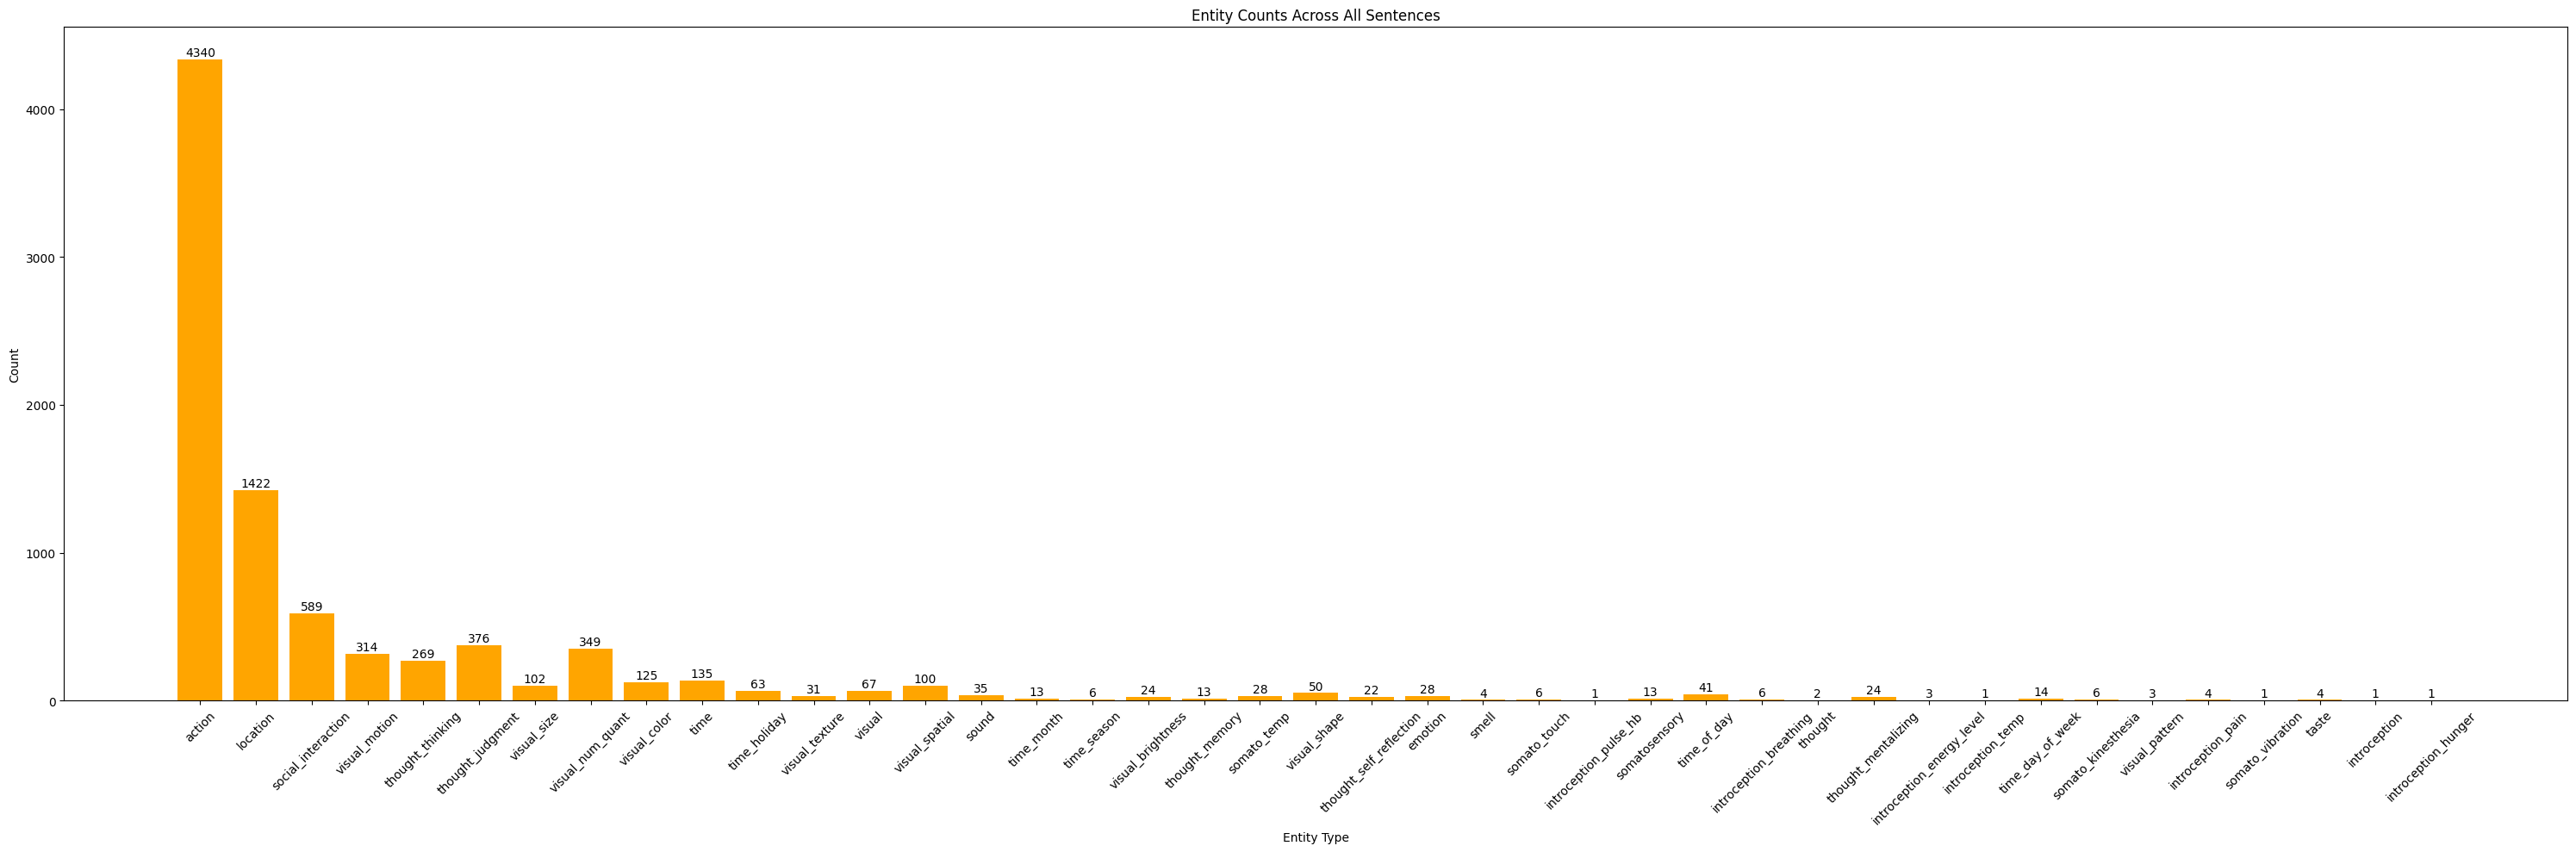

Bar chart with counts generated successfully!


In [ ]:
import os
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def process_json_file(file_path):
    with open(file_path, 'r') as file:
        json_data = json.load(file)

    content = json_data['content']
    sentence_pattern = r'(?<!\d\.)(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|!)\s+(?=[A-Z0-9])|(?<=\.|\?|!)\s*$|\r\n|\n'
    sentences = re.split(sentence_pattern, content.strip())

    entity_counts = Counter()

    for sentence in sentences:
        sentence = sentence.strip()
        if not sentence or len(sentence) < 3:  # Filter sentences with fewer than three characters
            continue

        start_index = content.index(sentence)
        end_index = start_index + len(sentence)

        for index, data in json_data['indexes'].items():
            if 'Entity' in data:
                for entity in data['Entity']:
                    # Check if the entity overlaps with the current sentence
                    if start_index <= entity['begin'] and entity['end'] <= end_index: # strict bounds:


                        # Increment the count for the entity's semantic label
                        entity_counts[entity['semantic']] += 1

    return entity_counts

def process_files_from_csv(csv_path, json_folder):
    df = pd.read_csv(csv_path)
    overall_entity_counts = Counter()

    for filename in df['Filename']:
        file_path = os.path.join(json_folder, filename)
        if os.path.exists(file_path):
            file_entity_counts = process_json_file(file_path)
            overall_entity_counts.update(file_entity_counts)
        else:
            print(f"File not found: {file_path}")

    return overall_entity_counts

# Paths
json_folder = "/content/drive/MyDrive/LLM for Medical Applications/LLM development/Annotated_179"
csv_folder = "/content/drive/MyDrive/LLM for Medical Applications/LLM development/Data/splits"

# Process files for each CSV and combine results
overall_counts = Counter()
for csv_file in ["best_dev_set.csv", "best_test_set.csv", "best_train_set.csv"]:
    csv_path = os.path.join(csv_folder, csv_file)
    overall_counts.update(process_files_from_csv(csv_path, json_folder))

# Generate bar chart with count annotations
labels, values = zip(*overall_counts.items())
plt.figure(figsize=(30, 10))
bars = plt.bar(labels, values, color='orange')

# Add count annotations on top of each bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, str(value),
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.title('Entity Counts Across All Sentences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("entity_counts_bar_chart_with_counts.png")
plt.show()

print("Bar chart with counts generated successfully!")

visual
Somatosensory
Smell
Sound
Taste
Introception
Time
Location
action
Social_Interaction
Emotion
Thought
Executive Function

| Category | Count |
|----------|-------|
| Action | 4340 |
| Location | 1422 |
| Visual | 1098 |
| Thought | 704 |
| Social Interaction | 589 |
| Time | 137 |
| Somatosensory | 41 |
| Sound | 35 |
| Emotion | 28 |
| Interoception | 16 |
| Smell | 4 |
| Taste | 4 |


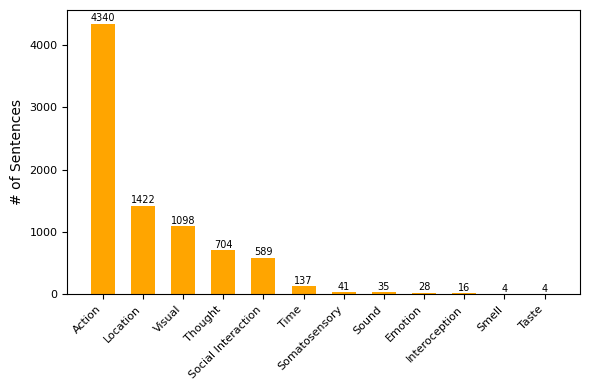

In [ ]:
import os
import json
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Function to process a single JSON file and count entities
def process_json_file(file_path):
    with open(file_path, 'r') as file:
        json_data = json.load(file)

    content = json_data['content']
    sentence_pattern = r'(?<!\d\.)(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|!)\s+(?=[A-Z0-9])|(?<=\.|\?|!)\s*$|\r\n|\n'
    sentences = re.split(sentence_pattern, content.strip())

    entity_counts = Counter()

    for sentence in sentences:
        sentence = sentence.strip()
        if not sentence or len(sentence) < 3:  # Filter sentences with fewer than three characters
            continue

        start_index = content.index(sentence)
        end_index = start_index + len(sentence)

        for index, data in json_data['indexes'].items():
            if 'Entity' in data:
                for entity in data['Entity']:
                    # Check if the entity overlaps with the current sentence
                   if start_index <= entity['begin'] and entity['end'] <= end_index: # strict bounds:

                        # Increment the count for the entity's semantic label
                        entity_counts[entity['semantic']] += 1

    return entity_counts

# Function to process all files listed in a CSV
def process_files_from_csv(csv_path, json_folder):
    df = pd.read_csv(csv_path)
    overall_entity_counts = Counter()

    for filename in df['Filename']:
        file_path = os.path.join(json_folder, filename)
        if os.path.exists(file_path):
            file_entity_counts = process_json_file(file_path)
            overall_entity_counts.update(file_entity_counts)
        else:
            print(f"File not found: {file_path}")

    return overall_entity_counts

# Paths
json_folder = "/content/drive/MyDrive/LLM for Medical Applications/LLM development/Annotated_179"
csv_folder = "/content/drive/MyDrive/LLM for Medical Applications/LLM development/Data/splits"

# Process files for each CSV and combine results
overall_counts = Counter()
for csv_file in ["best_dev_set.csv", "best_test_set.csv", "best_train_set.csv"]:
    csv_path = os.path.join(csv_folder, csv_file)
    overall_counts.update(process_files_from_csv(csv_path, json_folder))

# Define main categories and subcategories mapping
categories_mapping = {
    "Visual": ["visual_num_quant", "visual_motion", "visual_color", "visual_size",
               "visual_spatial", "visual_shape", "visual_texture", "visual_brightness",
               "visual_pattern"],
    "Somatosensory": ["somato_temp", "somato_touch", "somato_vibration",
                      "somato_kinesthesia"],
    "Smell": ["smell"],
    "Sound": ["sound"],
    "Taste": ["taste"],
    "Interoception": ["introception_pain", "introception_breathing",
                     "introception_energy_level", "introception_hunger",
                     "introception_temp", "introception_pulse_hb"],
    "Time": ["time_holiday", "time_of_day", "time_day_of_week",
             "time_month", "time_season"],
    "Location": ["location"],
    "Action": ["action"],
    "Social Interaction": ["social_interaction"],
    "Emotion": ["emotion"],
    "Thought": ["thought_memory", "thought_judgment",
                "thought_thinking", "thought_mentalizing",
                "thought_self_reflection"]
}

# Aggregate counts by main categories
aggregated_counts = {category: 0 for category in categories_mapping}
for category, subcategories in categories_mapping.items():
    aggregated_counts[category] += sum(overall_counts[subcategory] for subcategory in subcategories)


# Sort aggregated counts in descending order
sorted_aggregated_counts = dict(sorted(aggregated_counts.items(), key=lambda item: item[1], reverse=True))

# Generate Markdown table
print("| Category | Count |")
print("|----------|-------|")
for category, count in sorted_aggregated_counts.items():
    print(f"| {category} | {count} |")

# Generate condensed bar chart
labels, values = zip(*sorted_aggregated_counts.items())
# plt.figure(figsize=(10,5))
# bars = plt.bar(labels, values, color='orange')

# # Add count annotations on top of each bar
# for bar, value in zip(bars, values):
#     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, str(value),
#              ha='center', va='bottom', fontsize=10)

# plt.xlabel('')
# plt.ylabel('# of Sentences')
# plt.title('Distribution of the 12 main cognitive phenotypes')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.savefig("condensed_entity_counts_bar_chart_sorted.png")
# plt.show()

# print("Sorted condensed bar chart generated successfully!")

# Generate condensed bar chart with thinner bars
plt.figure(figsize=(6, 4))  # Reduced figure size
bars = plt.bar(labels, values, color='orange', width=0.6)  # Reduced bar width

# Add count annotations on top of each bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, str(value),
             ha='center', va='bottom', fontsize=7)  # Reduced font size

plt.xlabel('')
plt.ylabel('# of Sentences')
# plt.title('Distribution of the 12 main cognitive phenotypes')
plt.xticks(rotation=45, ha='right', fontsize=8)  # Reduced font size for x-axis labels
plt.yticks(fontsize=8)  # Reduced font size for y-axis labels
plt.tight_layout()
plt.savefig("condensed_entity_counts_bar_chart_sorted.png", dpi=300)  # Increased DPI for better quality
plt.show()



| Category | Count |
|----------|-------|
| Action | 4340 |
| Location | 1422 |
| Visual | 1098 |
| Thought | 704 |
| Social Interaction | 589 |
| Time | 137 |
| Somatosensory | 41 |
| Sound | 35 |
| Emotion | 28 |
| Introception | 16 |
| Smell | 4 |
| Taste | 4 |


| Category | Count |
|----------|-------|
| Action | 4340 |
| Location | 1422 |
| Perception | 1198 |
| Thought | 704 |
| Social Interaction | 589 |
| Time | 137 |
| Emotion | 28 |


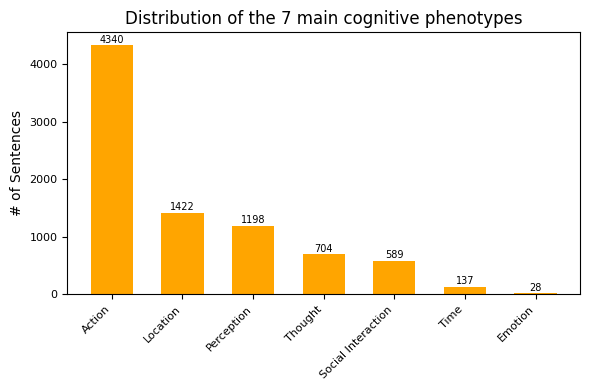

In [ ]:
import os
import json
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Function to process a single JSON file and count entities
def process_json_file(file_path):
    with open(file_path, 'r') as file:
        json_data = json.load(file)

    content = json_data['content']
    sentence_pattern = r'(?<!\d\.)(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|!)\s+(?=[A-Z0-9])|(?<=\.|\?|!)\s*$|\r\n|\n'
    sentences = re.split(sentence_pattern, content.strip())

    entity_counts = Counter()

    for sentence in sentences:
        sentence = sentence.strip()
        if not sentence or len(sentence) < 3:  # Filter sentences with fewer than three characters
            continue

        start_index = content.index(sentence)
        end_index = start_index + len(sentence)

        for index, data in json_data['indexes'].items():
            if 'Entity' in data:
                for entity in data['Entity']:
                    # Check if the entity overlaps with the current sentence
                   if start_index <= entity['begin'] and entity['end'] <= end_index: # strict bounds:

                        # Increment the count for the entity's semantic label
                        entity_counts[entity['semantic']] += 1

    return entity_counts

# Function to process all files listed in a CSV
def process_files_from_csv(csv_path, json_folder):
    df = pd.read_csv(csv_path)
    overall_entity_counts = Counter()

    for filename in df['Filename']:
        file_path = os.path.join(json_folder, filename)
        if os.path.exists(file_path):
            file_entity_counts = process_json_file(file_path)
            overall_entity_counts.update(file_entity_counts)
        else:
            print(f"File not found: {file_path}")

    return overall_entity_counts

# Paths
json_folder = "/content/drive/MyDrive/LLM for Medical Applications/LLM development/Annotated_179"
csv_folder = "/content/drive/MyDrive/LLM for Medical Applications/LLM development/Data/splits"

# Process files for each CSV and combine results
overall_counts = Counter()
for csv_file in ["best_dev_set.csv", "best_test_set.csv", "best_train_set.csv"]:
    csv_path = os.path.join(csv_folder, csv_file)
    overall_counts.update(process_files_from_csv(csv_path, json_folder))

# Define main categories and subcategories mapping
# Updated categories mapping with Perception domain
categories_mapping = {
    "Perception": [
        # Visual subcategories
        "visual_num_quant", "visual_motion", "visual_color", "visual_size",
        "visual_spatial", "visual_shape", "visual_texture", "visual_brightness", "visual_pattern",
        # Somatosensory
        "somato_temp", "somato_touch", "somato_vibration", "somato_kinesthesia",
        # Smell
        "smell",
        # Sound
        "sound",
        # Taste
        "taste",
        # Interoception
        "introception_pain", "introception_breathing", "introception_energy_level",
        "introception_hunger", "introception_temp", "introception_pulse_hb"
    ],
    "Time": ["time_holiday", "time_of_day", "time_day_of_week",
             "time_month", "time_season"],
    "Location": ["location"],
    "Action": ["action"],
    "Social Interaction": ["social_interaction"],
    "Emotion": ["emotion"],
    "Thought": ["thought_memory", "thought_judgment",
                "thought_thinking", "thought_mentalizing",
                "thought_self_reflection"]
}


# Aggregate counts by main categories
aggregated_counts = {category: 0 for category in categories_mapping}
for category, subcategories in categories_mapping.items():
    aggregated_counts[category] += sum(overall_counts[subcategory] for subcategory in subcategories)


# Sort aggregated counts in descending order
sorted_aggregated_counts = dict(sorted(aggregated_counts.items(), key=lambda item: item[1], reverse=True))

# Generate Markdown table
print("| Category | Count |")
print("|----------|-------|")
for category, count in sorted_aggregated_counts.items():
    print(f"| {category} | {count} |")

# Generate condensed bar chart
labels, values = zip(*sorted_aggregated_counts.items())
# plt.figure(figsize=(10,5))
# bars = plt.bar(labels, values, color='orange')

# # Add count annotations on top of each bar
# for bar, value in zip(bars, values):
#     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, str(value),
#              ha='center', va='bottom', fontsize=10)

# plt.xlabel('')
# plt.ylabel('# of Sentences')
# plt.title('Distribution of the 12 main cognitive phenotypes')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.savefig("condensed_entity_counts_bar_chart_sorted.png")
# plt.show()

# print("Sorted condensed bar chart generated successfully!")

# Generate condensed bar chart with thinner bars
plt.figure(figsize=(6, 4))  # Reduced figure size
bars = plt.bar(labels, values, color='orange', width=0.6)  # Reduced bar width

# Add count annotations on top of each bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, str(value),
             ha='center', va='bottom', fontsize=7)  # Reduced font size

plt.xlabel('')
plt.ylabel('# of Sentences')
plt.title('Distribution of the 7 main cognitive phenotypes')
plt.xticks(rotation=45, ha='right', fontsize=8)  # Reduced font size for x-axis labels
plt.yticks(fontsize=8)  # Reduced font size for y-axis labels
plt.tight_layout()
plt.savefig("condensed_entity_counts_bar_chart_sorted_7.png", dpi=300)  # Increased DPI for better quality
plt.show()



```
"### Task:
Your task is to identify and annotate specific medical entities in the given text. For each entity found, you should provide an output in JSON format that includes the following information: The start index of the entity in the text,The end index of the entity in the text, The extracted entity text, and The entity type

### Entity Markup Guides:
This sections entails the guideline for LLM’s training on our annotated data
Ex: use "visual" to denote a mention of visual elements.
use "visual_color" to denote mention of color of an object…

### Entity Definitions:
This sections entails the detailed definitions for each entity for the LLM’s training on our annotated data
Ex: visual: Perceptions related to sight, including attributes like color, size, shape, patterns, movement, and spatial relationships between objects.

### Input Text: "Morning Routine: Making breakfast and coffee
He woke up and went to his bathroom to brush his teeth and wash his face."
### Output Text: (
text ="Morning Routine: Making breakfast and coffee
He woke up and went to his bathroom to brush his teeth and wash his face."
annotations = {
    Annotation(start=17, end=33, term="Making breakfast", label="action"),
    Annotation(start=17, end=44, term="Making breakfast and coffee", label="action"),
    Annotation(start=49, end=56, term="woke up", label="action"),
    Annotation(start=61, end=81, term="went to his bathroom", label="action"),
    Annotation(start=69, end=81, term="his bathroom", label="location"),
    Annotation(start=85, end=100, term="brush his teeth", label="action"),
    Annotation(start=105, end=118, term="wash his face", label="action"),
}
)
```